In [12]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

plt.style.use('ggplot')

In [2]:
with open("../credenciales.json", 'r') as f:
    conn_data = json.load(f)

DB_CONN = f'mysql+mysqlconnector://{conn_data["username"]}:{conn_data["password"]}@{conn_data["host"]}/{conn_data["database"]}'

## cogiendo toda la base de datos


### carga de datos

se realiza inicialmente descripcion individual de las variables

las siguientes variables de la tabla `accountdata` no se tuvieron en cuenta:

| variable | razon |
|-----------|-----------|
| Username          | inicialmente no se ve que aporten a la clasificacion |
| Email             | inicialmente no se ve que aporten a la clasificacion |
| Armour            | inicialmente no se ve que aporten a la clasificacion |
| Health            | inicialmente no se ve que aporten a la clasificacion |
| x, y, z           | inicialmente no se ve que aporten a la clasificacion |
| Weapons           | inicialmente no se ve que aporten a la clasificacion |
| LastSerial        | inicialmente no se ve que aporten a la clasificacion |
| LastIP            | inicialmente no se ve que aporten a la clasificacion |
| weapstats         | inicialmente no se ve que aporten a la clasificacion |
| items             | inicialmente no se ve que aporten a la clasificacion |
| plrtosrvrsettings | inicialmente no se ve que aporten a la clasificacion |
| purgapoints | solo contiene valores de 0 |
| experiencia | solo contiene 2 valores distintos (0 y 150), se sospecha que no esta en uso |  
| JobRank | contiene demasiadas subclases y es dificil establecer una jerarquia entre ellas |
| GroupName | demasidas clases y dificl establecer jerarquia entre ellas |
| GroupRank | demasidas clases y dificl establecer jerarquia entre ellas |

In [63]:
SQL = """ 
SELECT 
    ad.Money,
    ad.Skin,
    ad.Interior,
    ad.Dimension,
    ad.Team,
    ad.Job,
    ad.Playtime_mins,
    ad.JailTime,
    ad.WL,
    ad.LastOnline,
    ad.Kills,
    ad.Deaths,
    ad.unemployedskin,
    ad.Drift_Points,

    COALESCE(ba.Balance, 0) AS Bank_money,

    ad.vip
FROM accountdata ad
LEFT JOIN bank_accounts ba ON ad.Username = ba.Account
"""

df = pd.read_sql(SQL, DB_CONN, parse_dates=["LastOnline"])

df["vip"] = df["vip"].map(lambda x: False if x in ["None", "false"] else True)

### preprocematientos

In [64]:
# PREPROCESAMIENTOS

# convertir variables string a minusculas
str_cols = df.select_dtypes(include="object").columns
df[str_cols] = df[str_cols].apply(lambda x: x.str.lower())

# filtrar y convertir variables Team y Job a "tiene Team" y "tiene Job" respectivamente 
# (se hace esto debido a que es dificil establecer una jerarquia en estas variables)
df = df[~df["Team"].isin(["nameless", "2cb", "frutiã±o"])]
df = df[~df["Job"].isin(["0", "banned"])]


df["Team"] = df["Team"].map(lambda x: True if x != "unemployed" else False)
df["Job"] = df["Job"].map(lambda x: True if x not in ["unemployed", "none"] else False)

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62347 entries, 0 to 62353
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Money           62347 non-null  int64         
 1   Skin            62347 non-null  int64         
 2   Interior        62347 non-null  int64         
 3   Dimension       62347 non-null  int64         
 4   Team            62347 non-null  bool          
 5   Job             62347 non-null  bool          
 6   Playtime_mins   62347 non-null  int64         
 7   JailTime        62347 non-null  int64         
 8   WL              62347 non-null  int64         
 9   LastOnline      62347 non-null  datetime64[ns]
 10  Kills           62347 non-null  int64         
 11  Deaths          62347 non-null  int64         
 12  unemployedskin  62347 non-null  int64         
 13  Drift_Points    62347 non-null  int64         
 14  Bank_money      62347 non-null  int64         
 15  vip    

### analisis descriptivo de las variables

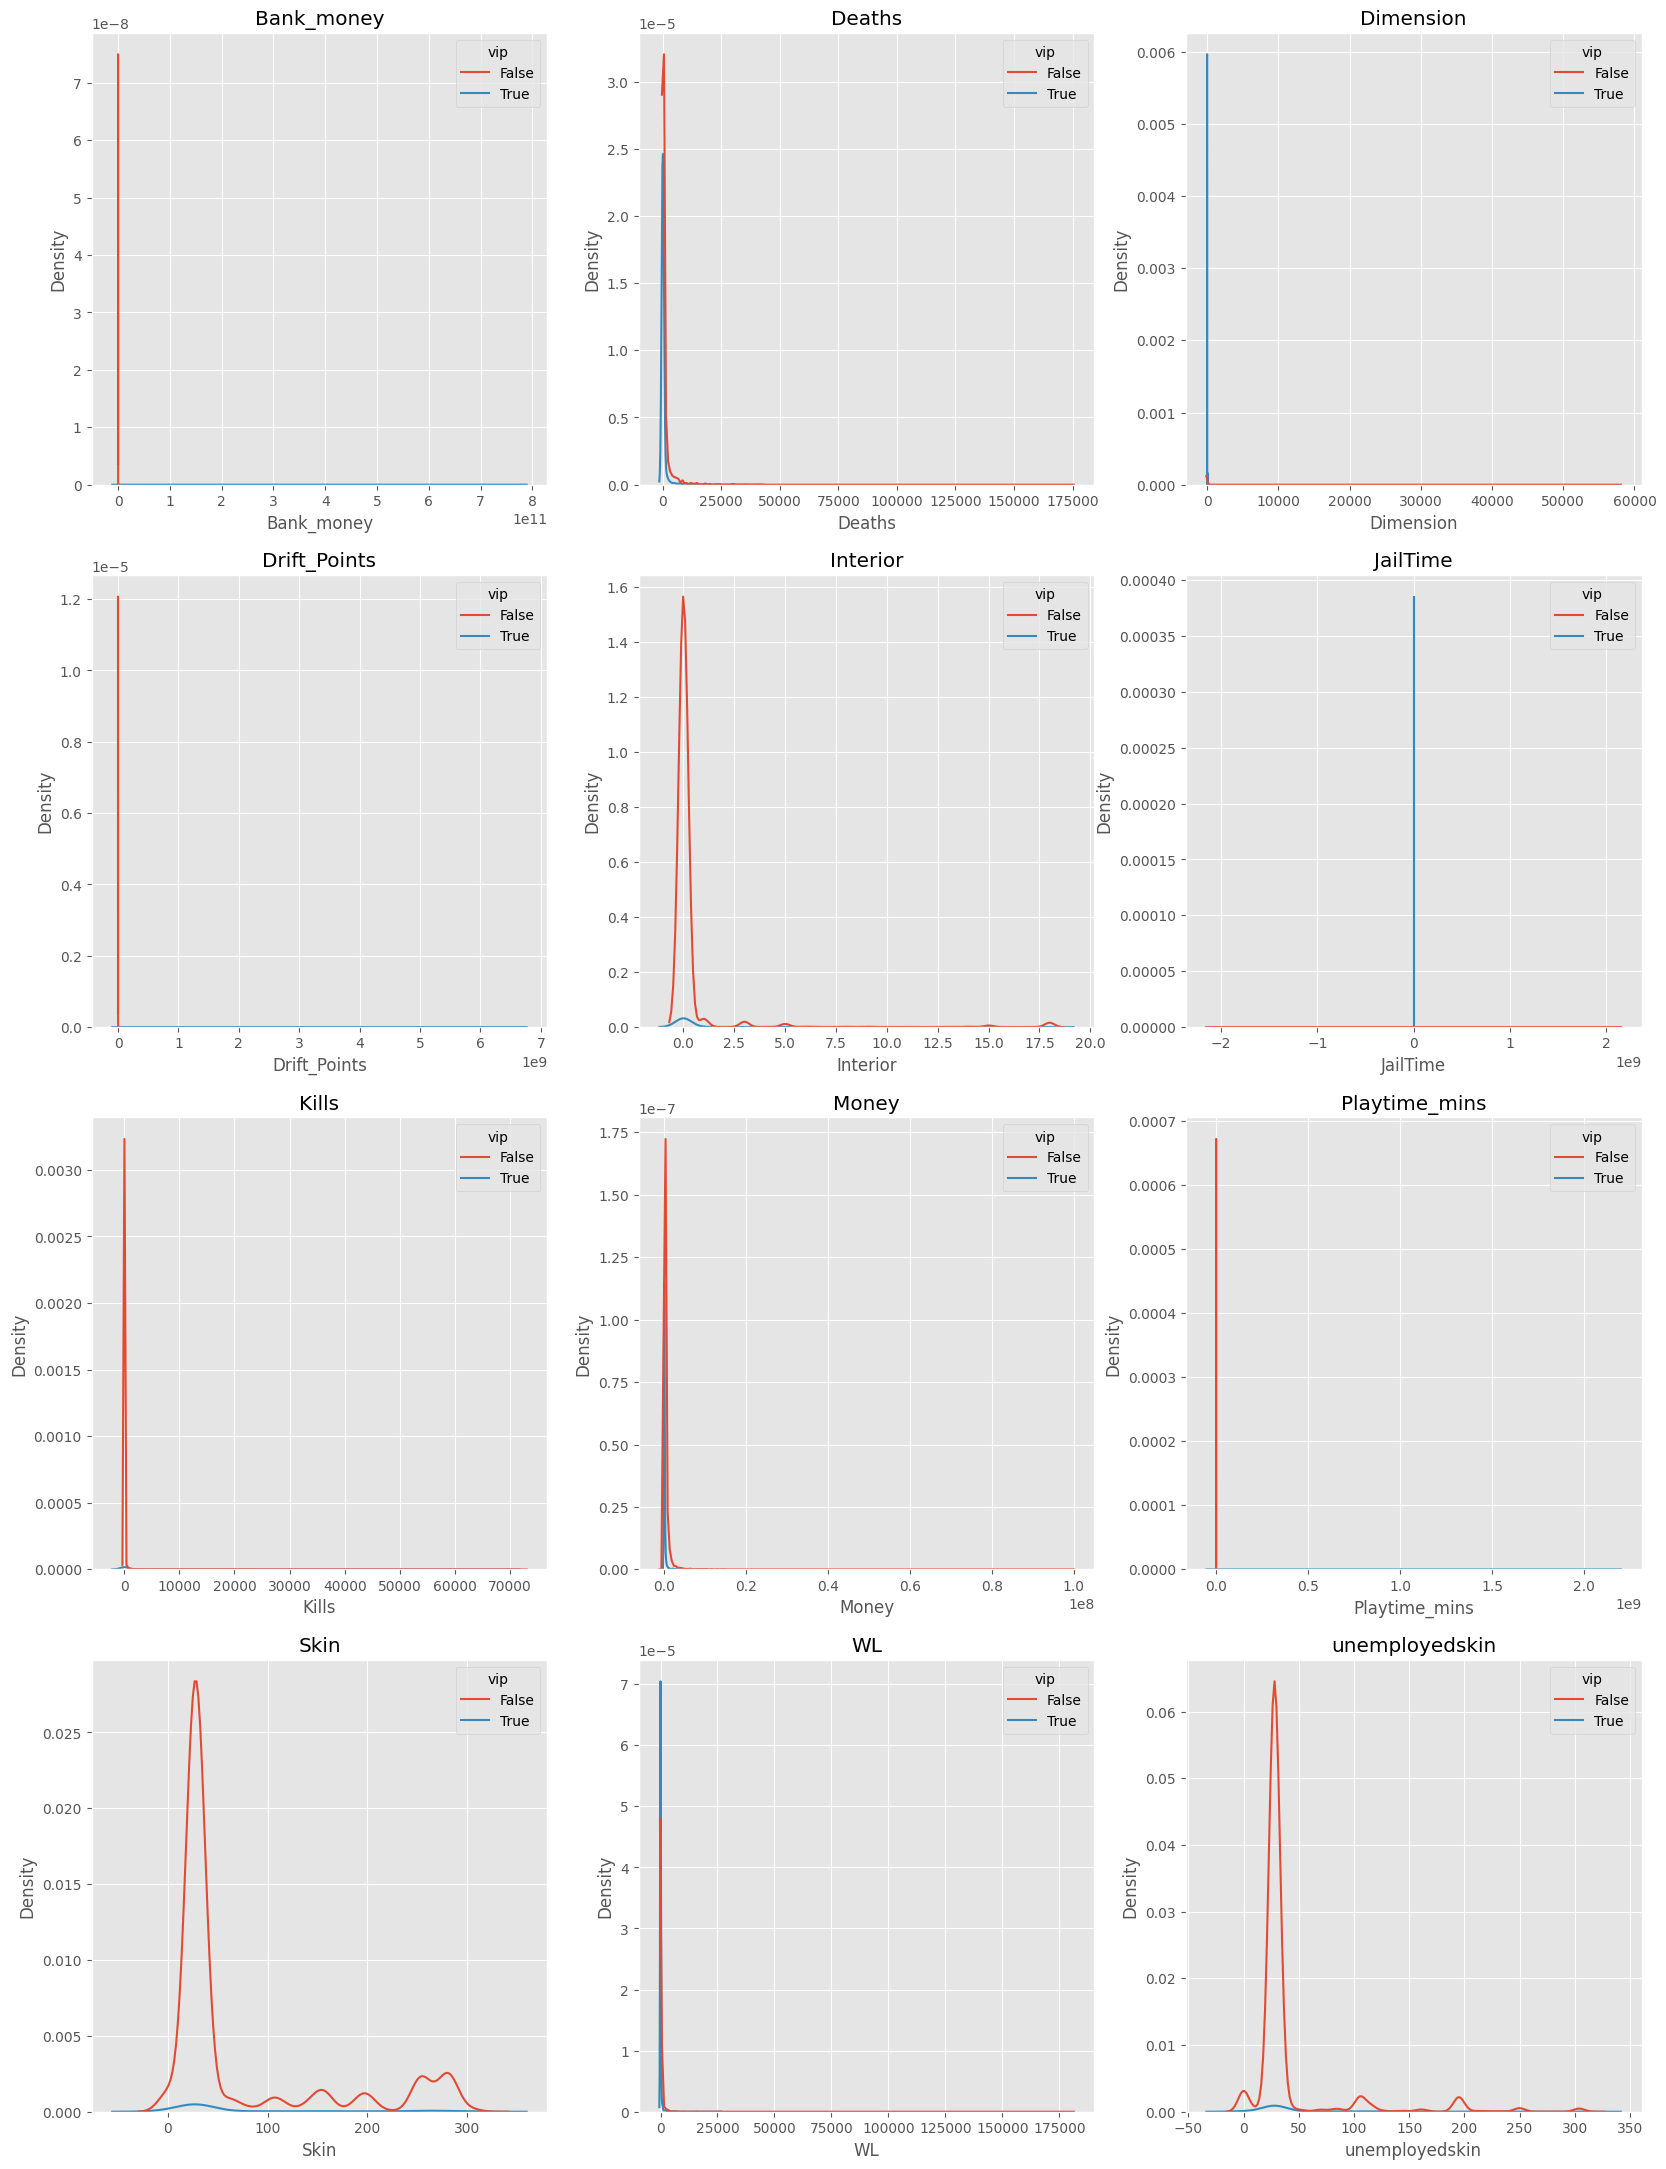

In [35]:
num_cols = df.select_dtypes(include=np.number).columns

num_cols = num_cols.difference(["vip"])

_, axes = plt.subplots(ceil(num_cols.size/3), 3, figsize=(20, 27))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.kdeplot(df, x=col, hue="vip", ax=axes[i])

    axes[i].set_title(col)

plt.show()

se observa que existen valores muy atipicos.

se ve claramente que algunas variables como "Bank_money", "Drift_Points", "JailTime", "Playtime_mins" distinguen muy bien los que han comprado VIP y los que no. sin embargo puede que los valores atipicos afecten este analisis

In [ ]:
# TODO
#  diagrama de barras para variables categoricas
#  ver que hacer con LastOnline
#  eliminar credenciales y commits con credenciales

## dsad